# 多智能体 RAG 系统 🤖🤝🤖

_作者: [Sergio Paniego](https://github.com/sergiopaniego)_

🚨 **注意**：本教程较为高级。在开始之前，你应该对以下教程中讨论的概念有充分的理解：
- [智能体教程](agents)
- [高级 RAG 教程](advanced_rag)

在本 Notebook 中，我们将创建一个 **多智能体 RAG 系统**，这是一个多个智能体协作检索和生成信息的系统，结合了 **基于检索的系统** 和 **生成模型** 的优势。

## 什么是多智能体 RAG 系统？ 🤔

**多智能体检索增强生成 (RAG)** 系统由多个智能体组成，这些智能体协作执行复杂的任务。检索智能体负责检索相关的文档或信息，而生成智能体则将这些信息综合起来生成有意义的输出。系统中还会有一个管理智能体，它负责协调各个智能体，并根据用户输入选择最合适的智能体来完成任务。

这个教程的原始概念来源于 [这篇文章](https://weaviate.io/blog/what-is-agentic-rag)。你可以在那里找到更多细节。

以下是我们将要构建的系统架构。

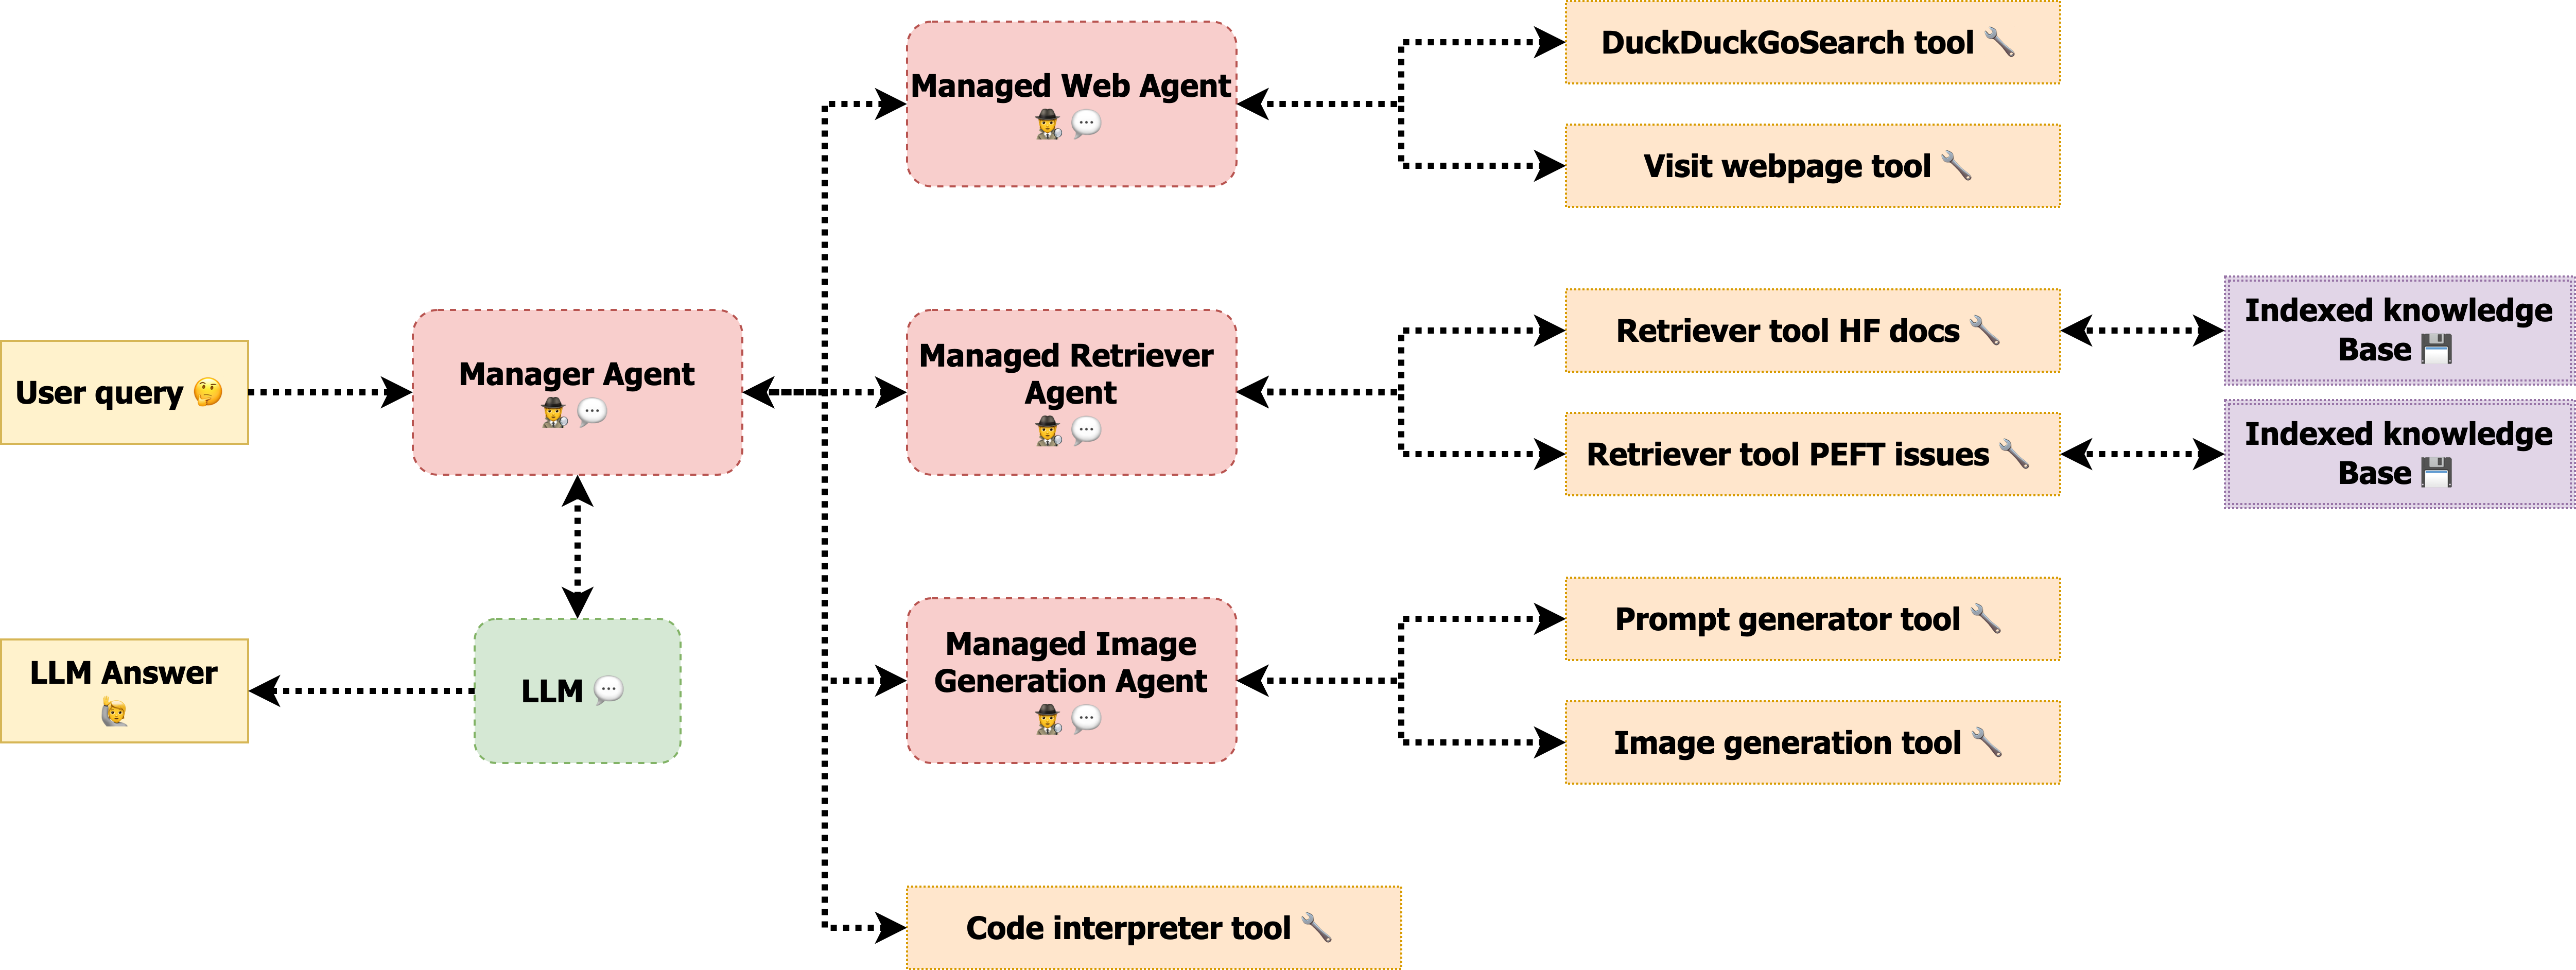

# 1. 安装依赖

首先，让我们安装依赖：

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git#egg=transformers[agents]

In [ ]:
!pip install markdownify duckduckgo-search spaces gradio-tools langchain langchain-community langchain-huggingface faiss-cpu --upgrade -q

让我们登录来调用 HF 推理 API

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

# 2. 创建我们的多智能体 RAG 系统

在本节中，我们将创建我们的 RAG 系统中所涉及的每个智能体。

我们将拥有 3 个由中央智能体管理的智能体（请参见图片了解详细信息）：

* **🕵💬 网络搜索智能体**：它将包含 [`DuckDuckGoSearchTool`](https://github.com/huggingface/transformers/blob/main/src/transformers/agents/search.py) 工具和 [`VisitWebpageTool`](https://github.com/huggingface/transformers/blob/main/src/transformers/agents/search.py) 工具。正如您所看到的，每个智能体可以包含一组工具。
* **🕵💬 检索智能体**：它将包含两个工具，用于从两个不同的知识库中检索信息。
* **🕵💬 图像生成智能体**：它将包含一个提示生成工具，并附带图像生成工具。

💡 除了这些智能体，**中央/协调智能体** 还将访问 **代码解释器工具** 以执行代码。

我们将使用 [Qwen/Qwen2.5-72B-Instruct](https://huggingface.co/Qwen/Qwen2.5-72B-Instruct) 作为每个组件的语言模型（LLM），该模型将通过推理 API 进行访问。根据智能体的不同，可能会使用不同的 LLM 模型。

> _注意：_ 推理 API 托管的模型根据不同的标准进行选择，已部署的模型可能会在没有通知的情况下更新或替换。了解更多信息，请访问 [此链接](https://huggingface.co/docs/api-inference/supported-models)。

In [ ]:
from transformers.agents import HfApiEngine

llm_model = "Qwen/Qwen2.5-72B-Instruct"
llm_engine = HfApiEngine(llm_model)

让我们深入了解每个智能体的详细信息！

## 2.1 网络搜索智能体 🔍

**网络搜索智能体**将使用 [`DuckDuckGoSearchTool`](https://github.com/huggingface/transformers/blob/main/src/transformers/agents/search.py) 来进行网页搜索并收集相关信息。这个工具充当搜索引擎，根据指定的关键词进行查询。

为了使搜索结果可操作，我们还需要让智能体能够访问 DuckDuckGo 检索到的网页。这可以通过使用内置的 [`VisitWebpageTool`](https://github.com/huggingface/transformers/blob/main/src/transformers/agents/search.py) 来实现。

让我们探索如何设置并将其集成到我们的系统中！

以下代码来自原始的 [让多个智能体在多智能体层级中协作 🤖🤝🤖](https://huggingface.co/learn/cookbook/multiagent_web_assistant) 示例，因此可以参考该教程了解更多细节。

### 2.1.1 构建我们的多工具网络智能体 🤖

现在我们已经设置了基本的搜索和网页工具，接下来让我们构建一个 **多工具网络智能体**。这个智能体将结合多个工具，执行更复杂的任务，并利用 `ReactJsonAgent` 的能力。

`ReactJsonAgent` 特别适合用于网络搜索任务，因为它的 JSON 动作形式只需要简单的参数，并且能够在单一动作的顺序链中无缝工作。这使得它成为搜索相关信息并从特定网页检索详细内容的理想选择。相比之下，`CodeAgent` 的动作形式更适合涉及多个或并行工具调用的场景。

通过集成多个工具，我们可以确保我们的智能体以更加复杂和高效的方式与网络进行交互。

让我们深入了解如何设置这个智能体，并将其集成到我们的系统中！

In [5]:
from transformers.agents import ReactCodeAgent, ReactJsonAgent, ManagedAgent
from transformers.agents.search import DuckDuckGoSearchTool, VisitWebpageTool

web_agent = ReactJsonAgent(
    tools=[DuckDuckGoSearchTool(), VisitWebpageTool()],
    llm_engine=llm_engine
)

现在我们已经创建了第一个智能体，接下来让我们将其包装为一个 `ManagedAgent`，这样中央智能体就可以使用它了。

In [6]:
managed_web_agent = ManagedAgent(
    agent=web_agent,
    name="search",
    description="Runs web searches for you. Give it your query as an argument.",
)

## 2.2 检索智能体 🤖🔍

我们的多智能体系统中的第二个智能体是 **检索智能体**。该智能体负责从不同来源收集相关信息。为了实现这一目标，它将利用两个工具，从两个独立的知识库中检索数据。

我们将重用在其他 RAG 示例中使用过的两个数据源，这将使检索器能够高效地收集信息，以供后续处理。

通过利用这些工具，检索智能体可以访问多样化的数据集，确保在将信息传递给系统的下一步之前，能够全面收集到相关的信息。

让我们探索如何设置检索器，并将其集成到我们的多智能体系统中！

### 2.2.1 HF 文档检索工具 📚

第一个检索工具来自于 [Agentic RAG: 使用查询重构和自我查询加速你的 RAG 🚀](https://huggingface.co/learn/cookbook/agent_rag) 示例。

对于这个检索器，我们将使用一个包含各种 `huggingface` 包文档页面的数据库，所有文档都存储为 Markdown 文件。这个数据集将作为检索智能体的知识库，用于搜索和检索相关的文档。

为了使我们的智能体能够轻松访问这个数据集，我们将执行以下步骤：

1. **下载数据集**：我们首先获取 Markdown 格式的文档。
2. **嵌入数据**：然后我们将使用 **FAISS 向量存储** 将文档转换为嵌入，以便高效地进行相似度搜索。

通过这种方式，检索工具可以根据搜索查询快速访问相关的文档片段，使智能体能够提供准确和详细的信息。

让我们继续设置这个工具，处理文档检索！

In [ ]:
import datasets

knowledge_base = datasets.load_dataset("m-ric/huggingface_doc", split="train")

In [ ]:
from tqdm import tqdm
from transformers import AutoTokenizer
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

source_docs = [
    Document(page_content=doc["text"], metadata={"source": doc["source"].split("/")[1]})
    for doc in knowledge_base
]

text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
    AutoTokenizer.from_pretrained("thenlper/gte-small"),
    chunk_size=200,
    chunk_overlap=20,
    add_start_index=True,
    strip_whitespace=True,
    separators=["\n\n", "\n", ".", " ", ""],
)

# Split docs and keep only unique ones
print("Splitting documents...")
docs_processed = []
unique_texts = {}
for doc in tqdm(source_docs):
    new_docs = text_splitter.split_documents([doc])
    for new_doc in new_docs:
        if new_doc.page_content not in unique_texts:
            unique_texts[new_doc.page_content] = True
            docs_processed.append(new_doc)

print("Embedding documents...")
embedding_model = HuggingFaceEmbeddings(model_name="thenlper/gte-small")
huggingface_doc_vector_db = FAISS.from_documents(
    documents=docs_processed,
    embedding=embedding_model,
    distance_strategy=DistanceStrategy.COSINE,
)

现在我们已经将文档嵌入到 FAISS 向量存储中，让我们创建 **RetrieverTool**。这个工具将查询 FAISS 向量存储，以根据用户的查询检索最相关的文档。

这将使检索智能体能够在收到查询时，访问并提供相关的文档内容。

In [9]:
from transformers.agents import Tool
from langchain_core.vectorstores import VectorStore

class RetrieverTool(Tool):
    name = "retriever"
    description = "Using semantic similarity, retrieves some documents from the knowledge base that have the closest embeddings to the input query."
    inputs = {
        "query": {
            "type": "string",
            "description": "The query to perform. This should be semantically close to your target documents. Use the affirmative form rather than a question.",
        }
    }
    output_type = "string"

    def __init__(self, vectordb: VectorStore, **kwargs):
        super().__init__(**kwargs)
        self.vectordb = vectordb

    def forward(self, query: str) -> str:
        assert isinstance(query, str), "Your search query must be a string"

        docs = self.vectordb.similarity_search(
            query,
            k=7,
        )

        return "\nRetrieved documents:\n" + "".join(
            [
                f"===== Document {str(i)} =====\n" + doc.page_content
                for i, doc in enumerate(docs)
            ]
        )

In [10]:
huggingface_doc_retriever_tool = RetrieverTool(huggingface_doc_vector_db)

### 2.2.2 PEFT 问题检索工具

对于第二个检索器，我们将使用 [PEFT 问题](https://github.com/huggingface/peft/issues) 作为数据源，正如在 [使用 Hugging Face Zephyr 和 LangChain 的简单 RAG 架构处理 GitHub 问题](https://huggingface.co/learn/cookbook/rag_zephyr_langchain) 中所示。

同样，以下代码来自该示例，因此可以参考该教程了解更多细节！

In [11]:
from google.colab import userdata
GITHUB_ACCESS_TOKEN = userdata.get('GITHUB_PERSONAL_TOKEN')

In [12]:
from langchain.document_loaders import GitHubIssuesLoader

loader = GitHubIssuesLoader(repo="huggingface/peft", access_token=GITHUB_ACCESS_TOKEN, include_prs=False, state="all")
docs = loader.load()

In [13]:
splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=30)
chunked_docs = splitter.split_documents(docs)

In [14]:
peft_issues_vector_db = FAISS.from_documents(chunked_docs, embedding=embedding_model)

现在，让我们使用相同的 `RetrieverTool` 来生成第二个检索工具。

In [15]:
peft_issues_retriever_tool = RetrieverTool(peft_issues_vector_db)

### 2.2.3 构建检索智能体

现在我们已经创建了两个检索工具，接下来是时候构建 **检索智能体** 了。这个智能体将管理这两个工具，并根据用户的查询检索相关信息。

我们将使用 `ManagedAgent` 来集成这两个工具，并将该智能体传递给中央智能体进行协调。这样，中央智能体就能够控制和调度检索智能体，从而确保系统在执行任务时能够有效地检索并提供信息。

In [16]:
retriever_agent = ReactJsonAgent(
    tools=[huggingface_doc_retriever_tool, peft_issues_retriever_tool], llm_engine=llm_engine, max_iterations=4, verbose=2
)

In [17]:
managed_retriever_agent = ManagedAgent(
    agent=retriever_agent,
    name="retriever",
    description="Retrieves documents from the knowledge base for you that are close to the input query. Give it your query as an argument. The knowledge base includes Hugging Face documentation and PEFT issues.",
)

## 2.3 图像生成智能体 🎨

系统中的第三个智能体是 **图像生成智能体**。该智能体将有两个工具：一个用于优化用户查询，另一个用于根据查询生成图像。在这种情况下，我们将使用 `CodeAgent` 而不是 `ReactAgent`，因为一组动作可以一次性执行。

关于图像生成智能体的更多细节，你可以参考 [Agents, supercharged - Multi-agents, External tools, and more](https://huggingface.co/docs/transformers/en/agents_advanced) 文档。

让我们深入了解这些工具如何协同工作，根据用户输入生成图像！

In [ ]:
from transformers import load_tool, CodeAgent

prompt_generator_tool = Tool.from_space("sergiopaniego/Promptist", name="generator_tool", description="Optimizes user input into model-preferred prompts")

In [ ]:
image_generation_tool = load_tool("m-ric/text-to-image", cache=False)
image_generation_agent = CodeAgent(tools=[prompt_generator_tool, image_generation_tool], llm_engine=llm_engine)

🖼 同样，我们使用 `ManagedAgent` 来告诉中央智能体它可以管理该智能体。此外，我们还包含了一个 `additional_prompting` 参数，以确保智能体返回生成的图像，而不仅仅是文本描述。


In [52]:
managed_image_generation_agent = ManagedAgent(
    agent=image_generation_agent,
    name="image_generation",
    description="Generates images from text prompts. Give it your prompt as an argument.",
    additional_prompting="\n\nYour final answer MUST BE only the generated image location."
)

# 3. 添加中央智能体管理器来协调系统

**中央智能体管理器**将负责协调各个智能体之间的任务。具体来说，它将：

- **接收用户输入**并决定由哪个智能体（网络搜索、检索、图像生成）来处理。
- **委派任务**给合适的智能体，依据用户的查询类型。
- **收集并综合**来自各个智能体的结果。
- **将最终输出**返回给用户。

我们将所有已经开发的智能体作为 `managed_agents` 添加进来，并在 `additional_authorized_imports` 中加入必要的代码执行器导入。这样，中央智能体管理器不仅能协调任务，还能确保系统能够根据不同的需求动态选择合适的智能体并执行复杂的操作。

In [53]:
manager_agent = ReactCodeAgent(
    tools=[],
    llm_engine=llm_engine,
    managed_agents=[managed_web_agent, managed_retriever_agent, managed_image_generation_agent],
    additional_authorized_imports=["time", "datetime", "PIL"],
)

现在，一切都已设置完毕，让我们测试多智能体 RAG 系统的性能！

为此，我们将提供一些示例查询，观察系统如何在智能体之间委派任务、处理信息并返回最终结果。

这将帮助我们了解智能体协作的效率和有效性，并在必要时识别出优化的方向。

让我们开始运行一些测试吧！

## 3.1 示例：触发搜索智能体

In [22]:
manager_agent.run("How many years ago was Stripe founded?")

======== New task ========
How many years ago was Stripe founded?
=== Agent thoughts:
Thought: To solve this problem, I need to find out the year Stripe was founded and then calculate the difference between the current year and the year of founding.
>>> Agent is executing the code below:
founding_year = search("When was Stripe founded?")
print(founding_year)
====
======== New task ========
You're a helpful agent named 'search'.
You have been submitted this task by your manager.
---
Task:
When was Stripe founded?
---
You're helping your manager solve a wider task: so make sure to not provide a one-line answer, but give as much information as possible so that they have a clear understanding of the answer.

Your final_answer WILL HAVE to contain these parts:
### 1. Task outcome (short version):
### 2. Task outcome (extremely detailed version):
### 3. Additional context (if relevant):

Put all these in your final_answer tool, everything that you do not pass as an argument to final_answer w

14

## 3.2  示例：触发图像生成智能体

In [54]:
result = manager_agent.run(
    "Improve this prompt, then generate an image of it.", prompt='A rabbit wearing a space suit'
)

======== New task ========
Improve this prompt, then generate an image of it.
You have been provided with these initial arguments: {'prompt': 'A rabbit wearing a space suit'}.
=== Agent thoughts:
Thought: I will first improve the prompt to make it more detailed and then use the `image_generation` tool to generate an image based on the improved prompt. I will store the improved prompt in a variable and print it for the next step.
>>> Agent is executing the code below:
improved_prompt = "A rabbit wearing a space suit, jumping in a zero-gravity environment, surrounded by stars and planets."
print(improved_prompt)
====
Print outputs:
A rabbit wearing a space suit, jumping in a zero-gravity environment, surrounded by stars and planets.

=== Agent thoughts:
Thought: Now that I have the improved prompt, I will use the `image_generation` tool to generate the image.
>>> Agent is executing the code below:
image_generation(improved_prompt)
====
======== New task ========
You're a helpful agent na

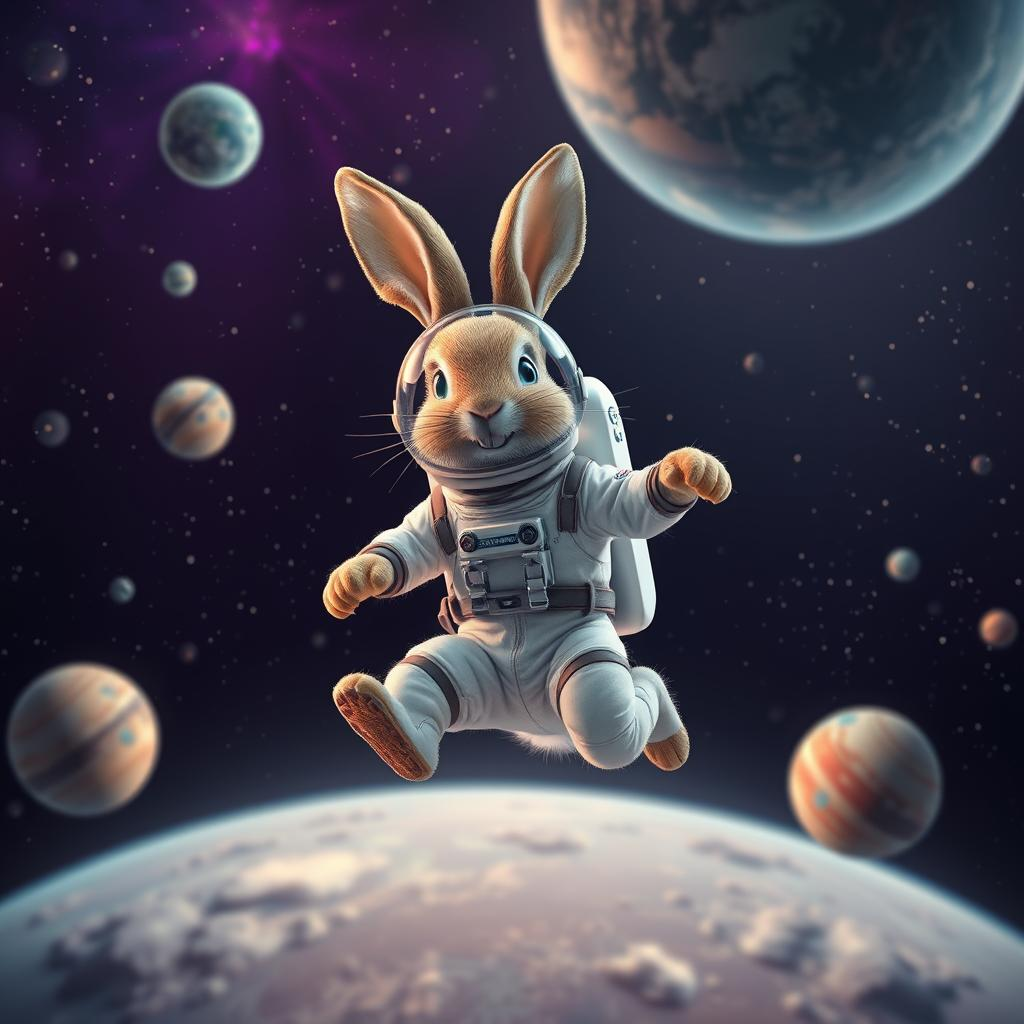

In [56]:
from IPython.display import Image, display
display(Image(filename=result))

## 3.3 示例：触发检索智能体以访问 Hugging Face 文档知识库

In [ ]:
manager_agent.run("How can I push a model to the Hub?")

======== New task ========
How can I push a model to the Hub?
=== Agent thoughts:
Thought: To provide instructions on how to push a model to the Hugging Face Hub, it would be most effective to retrieve official documentation or a guide that gives detailed steps. I'll use the `retriever` tool to find relevant information in the Hugging Face documentation or the PEFT issues section.
>>> Agent is executing the code below:
retriever(query="How to push a model to the Hugging Face Hub")
====
Code execution failed due to the following error:
ManagedAgent.__call__() missing 1 required positional argument: 'request'
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/transformers/agents/agents.py", line 1135, in step
    result = self.python_evaluator(
  File "/usr/local/lib/python3.10/dist-packages/transformers/agents/python_interpreter.py", line 902, in evaluate_python_code
    result = evaluate_ast(node, state, static_tools, custom_tools, authorized_imports)
  

"\n1. **Prepare Your Model**: Ensure your model is trained and saved in a format compatible with the Hugging Face Transformers library. This typically involves saving the model and tokenizer using the `save_pretrained` method.\n\n2. **Install Dependencies**: Install the `huggingface_hub` library if you haven't already. You can do this using pip:\n   ```bash\n   pip install huggingface_hub\n   ```\n\n3. **Login to Hugging Face**: You need to be logged in to your Hugging Face account. Use the `huggingface-cli` to log in:\n   ```bash\n   huggingface-cli login\n   ```\n   This will prompt you to enter your Hugging Face API token, which you can find in your account settings on the Hugging Face website.\n\n4. **Create a Repository**: Create a new repository on the Hugging Face Hub using the `create_repo` command. Replace `<model_name>` with the name you want for your model:\n   ```bash\n   huggingface-cli repo create <model_name> --organization <your_organization> --private\n   ```\n   If yo

## 3.4 示例：触发检索智能体以访问 PEFT 问题知识库

In [ ]:
manager_agent.run("How do you combine multiple adapters in peft?")

======== New task ========
How do you combine multiple adapters in peft?
=== Agent thoughts:
Thought: To combine multiple adapters in PEFT, I need to understand the mechanism for doing so. I will use the `retriever` tool to search for relevant information in the PEFT documentation or issues.
>>> Agent is executing the code below:
retriever(query="combine multiple adapters in peft")
====
Code execution failed due to the following error:
ManagedAgent.__call__() missing 1 required positional argument: 'request'
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/transformers/agents/agents.py", line 1135, in step
    result = self.python_evaluator(
  File "/usr/local/lib/python3.10/dist-packages/transformers/agents/python_interpreter.py", line 902, in evaluate_python_code
    result = evaluate_ast(node, state, static_tools, custom_tools, authorized_imports)
  File "/usr/local/lib/python3.10/dist-packages/transformers/agents/python_interpreter.py", line 782, i

'\nCombining multiple adapters in PEFT is possible but has some limitations:\n1. Only adapters of the same type (e.g., LoRA, IA3) can be loaded and inferred together.\n2. Use the `add_weighted_adapter` function to add and merge adapters.\n3. Merging adapter heads is not fully implemented and may require manual handling.\n\nTo combine multiple adapters:\n1. Ensure all adapters are of the same type.\n2. Use the `add_weighted_adapter` function to merge adapters with weighted contributions.\n3. Manually handle the merging of adapter heads if necessary.\n'

🏁 **最终思考**

我们已经成功构建了一个多智能体 RAG 系统，该系统集成了网络搜索、文档检索和图像生成智能体，所有智能体都由中央智能体管理器协调。这个架构使得任务能够无缝分配，处理效率高，并且能够灵活地处理各种用户查询。

🔍 **深入探索**

- [智能体指南](agents)
- [高级 RAG 指南](advanced_rag)
- [更多指南](https://huggingface.co/learn/cookbook/index)
- [了解更多关于 Agentic RAG](https://weaviate.io/blog/what-is-agentic-rag)

感谢你跟随我们完成这一旅程！希望这个系统能为你带来更多灵感，帮助你构建更智能、更高效的应用。